In [11]:
from sympy import symbols, diff, solve
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from http.client import HTTPResponse, IncompleteRead
import time

def patch_http_response_read(func):
    def inner(*args):
        try:
            return func(*args)
        except IncompleteRead as e:
            return e.partial
    return inner

HTTPResponse.read = patch_http_response_read(HTTPResponse.read)

# 线性回归

## 分类和回归
监督式学习的主要应用场景有两个：分类和回归。

分类就是给定特征向量，预测类别，也就是分类的输出是离散的；

回归是根据数据集$D$拟合一条曲线，输入某个$x$后，能够输出对应的预测结果，其输出是连续的，因此回归也叫做拟合(Fit)。

## 数据集的分布
在[之前](./theory.ipynb)我们讨论过某个分布$\mathcal{D}$，这是特征的分布，比如人类的身高不会异常高也不会过于矮小，而在父亲身高确定的条件下，儿子的身高也会服从$P(Y|X)$。

那么$\mathcal{D}$服从$X$和$Y$的联合分布
$$D\sim\mathcal{D}=P(X,Y)$$

## 噪音
假设线性回归的上帝函数$f$是直线，那么$y$的值是在$f(x)$的上下浮动，可以使用某个分布$\epsilon$来描述：

$$y=f(\boldsymbol{x})+\epsilon=\boldsymbol{w}\cdot\boldsymbol{x}+b+\epsilon$$

这里$\epsilon$也被称为噪音，并且其期望$E(\epsilon)=0$

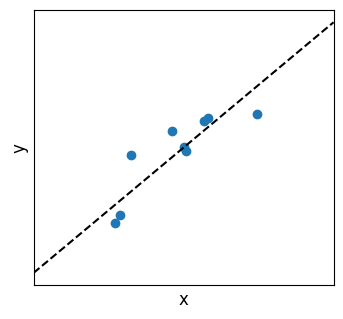

In [16]:
x_min, x_max = 1, 2.5

# 上帝函数 y=f(x)
def f(x):
	return 0.51*x+0.86

# 上帝分布 P(Y|X)
def P(X):
    # f(x) 加上期望为 0，标准差为 0.1 正态分布的噪音
	return f(X) + np.random.normal(loc = 0, scale=0.1, size=X.shape) 

# 通过 P(X, Y) 生成数据集 D
# X 服从期望为 1.718，标准差为 0.3 的正态分布
X = np.random.normal(loc = 1.718, scale=0.3, size=10) 
y = P(X)

# 绘制代码
# 设置字体大小
plt.rcParams.update({'font.size': 12})
# 设置subfigure
fig, ax = plt.subplots(figsize = (6, 3))
plt.subplots_adjust(left=0.25, right=0.75, top=0.999, bottom=0.08)
ax.set_xlabel('x'),ax.set_ylabel('y')
ax.set(xticks=[], yticks=[])
ax.set_xlim(x_min, x_max)

# 绘制数据集
ax.scatter(x=X, y=y)

# 绘制 f(x)
xx = np.linspace(x_min, x_max)
ax.plot(xx, f(xx), 'k--')

plt.show()

## 线性回归
线性回归在二维空间下是拟合一条直线，在三维下是拟合一个平面，更高维下就是拟合一个超平面，因此线性回归的假设空间维

$$\mathcal{H}=\{h(\boldsymbol{x})=\boldsymbol{w}\cdot\boldsymbol{x}+b\}$$

### 经验误差
线性回归的经验误差为
$$\hat{R}_D(h) =\frac{1}{|D|}\sum_{i}\Big(y_i-h(x_i)\Big)^2=\frac{1}{|D|}\sum_{i}\Big(y_i-(\boldsymbol{w}\cdot\boldsymbol{x_i}+b)\Big)^2$$

根据[经验误差最小原则](./theory.ipynb#经验误差最小原则)，那么可以根据$\hat{R}_D(h)$来计算出来$\boldsymbol{w}$和$b$

$$\hat{\boldsymbol{w}},\hat{b}=\operatorname*{argmin}_{\boldsymbol{w},b}\hat{R}_D(h)$$

由于$\hat{R}_D(h)$是凸函数，因此必定存在最小值，可以通过求导计算处$\boldsymbol{w}$和b

$$
\begin{cases}
    \displaystyle\frac{\partial }{\partial w}\hat{R}_D(h)=0\\
    \displaystyle\frac{\partial }{\partial b}\hat{R}_D(h)=0
\end{cases}
\implies \hat{\boldsymbol{w}}=?,\hat{b}=?
$$

并且计算出来的$\hat{\boldsymbol{w}}, \hat{b}$是$\boldsymbol{w}, b$的无偏估计。

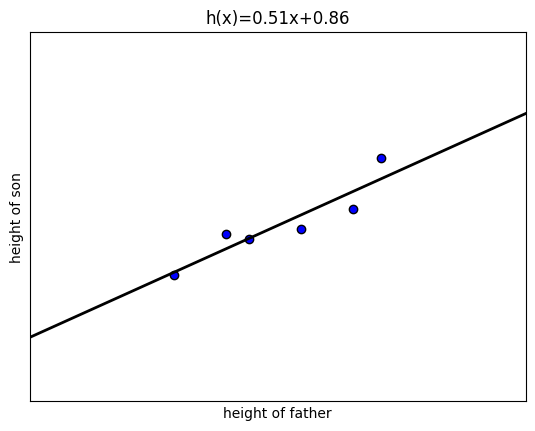

In [15]:
# 数据集 D
# 父亲身高 => 儿子身高
X = np.array([1.51, 1.64, 1.6, 1.73, 1.82, 1.87])
y = np.array([1.63, 1.7, 1.71, 1.72, 1.76, 1.86])

# 构造经验误差函数
w, b = symbols('w b', real=True)
RDh = 0
for (xi, yi) in zip(X, y):
	RDh += (yi - (xi*w + b))**2
RDh *= 1/len(X)

# 对 w 和 b 求偏导
eRDhw = diff(RDh, w)
eRDhb = diff(RDh, b)

# 求解方程组
ans = solve((eRDhw, eRDhb), (w, b))

ax = plt.subplot()
ax.set_xticks([]), ax.set_yticks([])
ax.set_xlabel("height of father")
ax.set_ylabel("height of son")
x_min, x_max = X.min()-0.25, X.max()+0.25
y_min, y_max = y.min()-0.25, y.max()+0.25
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.scatter(x=X, y=y, c="blue", marker="o", edgecolors='k')
xx=np.linspace(x_min, x_max)
yy=ans[w]*xx+ans[b]
ax.plot(xx, yy, color="black", linewidth=2)
ax.set_title(f"h(x)={ans[w]:.2f}x+{ans[b]:.2f}")
plt.show()


### 最小二乘法

由于线性回归的经验误差$\hat{R}_D(h)$是平方和，因此求解$\operatorname*{argmin}_{\boldsymbol{w},b}\hat{R}_D(h)$的方法也被称为最小二乘法。

在前面我们介绍了一个特征的求解方法，通过对$\hat{R}_D(h)$求导计算得到$\hat{\boldsymbol{w}}$和$\hat{b}$。当存在多个特征时，使用求导的计算方法会导致计算量过大，这里我们通过矩阵运算来推导一个更高效的方法来求解$\operatorname*{argmin}_{\boldsymbol{w}, b}\hat{R}_D(h)$

#### 最小二乘法的矩阵算法
首先将超平面$h$改写为
$$y=\boldsymbol{w}\cdot\boldsymbol{x}=\boldsymbol{w}^\mathrm{T}\boldsymbol{x}$$
其中
$$\boldsymbol{w}=\begin{pmatrix}b\\w_1\\w_2\\\vdots\\w_n\end{pmatrix},\quad\boldsymbol{x}=\begin{pmatrix}1\\x_1\\x_2\\\vdots\\x_n\end{pmatrix}$$

接下来改写经验误差函数$\hat{R}_D(h)$
$$
\begin{align}
    A
        &=(y_1-\boldsymbol{w}^\mathrm{T}\boldsymbol{x_1}, y_2-\boldsymbol{w}^\mathrm{T}\boldsymbol{x_2}, ..., y_n-\boldsymbol{w}^\mathrm{T}\boldsymbol{x_n})\\\\
        &=(y_1, ..., y_n)-(\boldsymbol{w}^\mathrm{T}\boldsymbol{x_1}, ..., \boldsymbol{w}^\mathrm{T}\boldsymbol{x_n})\\\\
        &=\boldsymbol{Y}^\mathrm{T}-\boldsymbol{w}\mathrm{T}\boldsymbol{X}\mathrm{T}\\\\\\\\

    \hat{R}_D(h)
        &=\frac{1}{n}AA^{\text{T}}\\\\
        &=\frac{1}{n}\left(Y^{\text{T}}-\boldsymbol{w}^\text{T}X^{\text{T}}\right)\left(Y^{\text{T}}-\boldsymbol{w}^\text{T}X^{\text{T}}\right)^{\text{T}}\\\\
        &=\frac{1}{n}\left(Y^{\text{T}}-\boldsymbol{w}^\text{T}X^{\text{T}}\right)\left(Y-X\boldsymbol{w}\right)\\\\
        &=\frac{1}{n}(\boldsymbol{w}^\text{T}X^{\text{T}}X\boldsymbol{w}-2\boldsymbol{w}^\text{T}X^{\text{T}}Y+Y^{\text{T}}Y)
\end{align}
$$

最后对经验误差函数$\hat{R}_D(h)$求导
$$\frac{\mathrm{d}}{\mathrm{d}\boldsymbol{w}}\hat{R}_D(h)=\frac{2}{|D|}X^{\text{T}}X\boldsymbol{w}-\frac{2}{|D|}X^{\text{T}}Y$$

那么
$$\boldsymbol{\hat{w}}=\left(X^{\text{T}}X\right)^{-1}X^{\text{T}}Y=X^{\dagger}Y$$

其中$X^{\dagger}$在数学中称为伪逆，这种方法叫做最小二乘法的矩阵算法，并且只有$X$是列满秩的，$X^{\dagger}$才存在。

$$

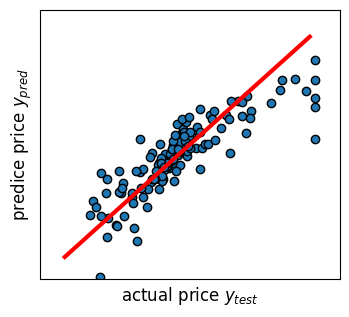

In [10]:
def load_boston():
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    retry = 10
    last_error = None
    while retry > 0:
        try:
            raw_df = pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)
            data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
            target = raw_df.values[1::2, 2]
            return data, target
        except Exception as e:
            last_error = e
            retry -= 1
            time.sleep(3)
            
    raise RuntimeError(f"fail to download data from {data_url}, error: {last_error}")

X, y = load_boston()

# 没有超参数，因此只需要训练集和测试集
X0_train, X0_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state = 0)

# 训练和预测
# 构造 X_train，即给 X0_train 增加一行 1
ones = np.ones(X0_train.shape[0]).reshape(-1, 1)
X_train = np.hstack((ones, X0_train))

pinvX_train = np.linalg.pinv(X_train) # 计算伪逆
w = np.matmul(pinvX_train, y_train) # 最小二乘法的矩阵算法

# 构造 X_test，即给 X0_test 增加一行 1
ones = np.ones(X0_test.shape[0]).reshape(-1, 1)
X_test = np.hstack((ones, X0_test))

# 根据训练出来的 w ，给出预测房价 y_pred
y_pred = np.matmul(X_test, w) # 求出 y_pred

plt.rcParams.update({'font.size': 12})
# 设置画布和坐标系
fig, ax = plt.subplots(figsize = (6, 3), nrows=1, ncols=1)

fig.subplots_adjust(left=0.25, right=0.75, top=0.999, bottom=0.1, )
xy_min, xy_max = -5, 55
ax.set_xticks(()),ax.set_yticks(())
ax.set_xlim(xy_min, xy_max),ax.set_ylim(xy_min, xy_max)
ax.set_xlabel('actual price $y_{test}$'),ax.set_ylabel('predice price $y_{pred}$')

# 绘制点 (y_test, y_pred)
ax.scatter(x=y_test, y=y_pred, edgecolor='k',)

# 绘制直线 y_test=y_pred
xx = np.arange(xy_min + 5, xy_max - 5)
yy = xx
plt.plot(xx, yy, color = 'red', lw = 3)

plt.show()